# **Metabolomics Data Visualisation Workflow for ANN-SS (DN-CG) [W/ SMOTE]**

This Google Colab notebook describes the metabolomics data analysis and visualisation workflow for a 2 layer artificial neural network with layer 1 consisting of multiple neurons (n = 2 to 6) with a sigmoidal activation, and layer 2 (output layer) consisting of a single neuron with a sigmoidal activation function (ANN-SS) for a binary classification outcome.

This computational workflow is described using a previously published LC-MS dataset by Sinclair et al. (2021). The study compared the metabolomic profiles across Parkinson's disease patients, characterised as medicated (MD; n=138) and drug-naive (DN; n=80), versus control (CG; n=56) using 8765 named metabolites. For the purpose of this computational workflow, only the DN vs CG samples were compared in a binary discriminant analysis. The deconvolved and annotated data from this study is deposited on Metabolomics Workbench (Study ID: MTBLS2266)

This computational workflow requires a dataset to be in, or converted to, a previously described standardised Excel file format (Mendez et al. 2019). This format uses the Tidy Data Framework (Wickham, 2014), where each row represents an observation (e.g. sample) and each column represents a variable (e.g. age or metabolite). Each excel file (per study) contains two sheets; a data sheet and a peak sheet. The data sheet contains the metabolite concentration together with the metadata associated for each observation (requiring the inclusion of the columns: Idx, SampleID, and Class). The peak sheet contains the additional metadata that pertains to the metabolites in the data sheet (requiring the inclusion of the columns: Idx, Name, and Label). The standardisation of this format allows for the efficient re-use of this computational workflow.

The steps included in this data analysis and visualisation workflow are:
1. Import Packages 
2. Load Data and Peak Sheet
3. Data Pre-processing
4. Split Data into Train and Test Set
5. Hyperparameter Optimisation
6. Build Model and Evaluate
7. Permutation Testing
8. Loss Function

# Section 1 - Import Packages

Certain packages need installing onto the virtual environment prior to use.

For this computational workflow the CIMCB package was installed using pip, CIMCB requires:

*   Python (>=3.5)
*   Bokeh (>=1.0.0)
*   Keras
*   NumPy (>=1.12)
*   SciPy
*   scikit-learn
*   Statsmodels
*   TensorFlow
*   tqdm

In [53]:
pip install cimcb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use tools that extend beyond the basic functionalities of Python programming, packages must first be imported to enable their use in each Google Colab environment. Each package is a container of modules.

For this computational workflow, the following packages were used:


*   numpy: A fundamental package for scientific computing with Python, primarly used for the manipulation of arrays
*   pandas: A fundamental package for data analysis and manipulation
*   cimcb: A package for the statistical analysis of untargeted and targeted metabolomics data
*   matplotlib.pyplot: A package mainly used for interactive plots and simple cases of programmatic plot generation
*   seaborn: A package that provides a high-level interface for drawing attractive and informative statistical graphics
*   sklearn: A fundamental package containing tools for machine learning
  *   train_test_split: A method to split arrays into training and test subsets

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import cimcb as cb

print('All packages successfully loaded')

All packages successfully loaded


In order to  reproducibility of the workflow, random seeds are set.

*   seed_split: Seed the generator using an integer value e.g. 42 (default = None ; no seed set)

This seed is used to mainatin duplicability in the way the data is divided when the train and test set are generated.

*  seed_init: seed the generator using an integer value e.g. 42 (default = None ; no seed set)

This seed is used to maintain duplicability in the way the intial weights are drawn from a truncated normal distribution when the neural network is first compiled.

In [55]:
seed_split = 100
seed_init = 4
# seed_split = None
# seed_init = None

# Section 2 - Load Data & Peak Sheet

To upload the dataset to the Google Colab notebook environment, an upload widget was used.

In [56]:
from google.colab import files

uploaded = files.upload()

Saving Data and Peak sheet_Test2.xlsx to Data and Peak sheet_Test2 (1).xlsx


The helper function load_dataXL loads the two data sheets from the Excel file 'Data and Peak sheet_Test.xlsx'. Provided the dataset adheres to the standardised TidyData framework format, load_dataXL() outputs the data sheets from the uploaded Excel file as individual Pandas DataFrames.

In [57]:
# The path to the input file (Excel spreadsheet)
filename = 'Data and Peak sheet_Test2.xlsx'
#filename = 'MTBLS290db.xlsx'

# Load Peak and Data tables into two variables
dataTable, peakTable = cb.utils.load_dataXL(filename, DataSheet='Data', PeakSheet='Peaks')

Loadings PeakFile: Peaks
Loadings DataFile: Data
Data Table & Peak Table is suitable.
TOTAL SAMPLES: 418 TOTAL PEAKS: 8765
Done!


# Section 3 - Data Pre-processing

**Section 3.1 - Data Cleaning**

According to Broadhurst (2019), it is best practice to access the quality of the data and refine the dataset by removing those metabolites that lack reporducible measurements. The QC-RSD and percentage of missing values has been calculated and are included in the peakTable DataFrame. Using those values, we remove all metabolomic features that do not meet the following criteria:

*   QC-RSD less than 20%
* Fewer than 10% of values are missing

In [58]:
# Clean PeakTable
RSD = peakTable['QC_RSD']   
percMiss = peakTable['Perc_missing']  
peakTableClean = peakTable[(RSD < 20) & (percMiss < 10)]   
peakList = peakTableClean['Name']  

print("Number of peaks remaining: {}".format(len(peakTableClean)))

Number of peaks remaining: 2261


**Section 3.2 - Extract X and Y**

As previously mentioned, this workflow is performing binary classification of the classes MD vs CG. The X matrix of metabolite concentrations and Y vector of classification labels ("DN"=0 and "CG"=1) are extracted through the following steps:

1.   Create a subset of the dataTable called dataTable1, containing samples in the Class "DN" or "CG"
2.   Use the peakList variable to hold the names of the metabolites to be used 
3.   Extract all the applicable columns, using peakList, from dataTable1 and place in matrix X
4.   Set Y to the list of binary outcomes from the "Class" column from dataTable1

In [59]:
# Extract PeakList
dataTable1 = dataTable[(dataTable.Class == "DN") | (dataTable.Class == "CG")]  # Reduce data table only to MD and CG class members
pos_outcome = "CG"

dataTable1['Class'] = [0 if x == 'DN' else 1 for x in dataTable1['Class']]

to_drop = ['Idx', 'SampleID', 'SampleType']
dataTable1.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [60]:
peaklist = peakTableClean['Name']          
X = dataTable1[peaklist]

merged = pd.concat([dataTable1['Class'], X], axis=1)

merged.reset_index()

,index,Class,M86,M132,M137,M152,M155,M162,M164,M169,...,M8608,M8612,M8642,M8655,M8663,M8685,M8699,M8715,M8729,M8731
0,289,1,455.705420,74547.90860,17517.427050,252339.34040,3.307946e+06,15500.163770,69185.64871,1.901201e+04,...,53984.35891,12340.56516,3.188476e+05,9.179140e+05,231634.10350,11934.087450,3625.328173,389606.2906,496740.5406,62730.39763
1,290,1,6364.059479,131876.97490,24767.199200,67895.10762,1.409967e+06,424.622469,95029.65119,3.023538e+04,...,42381.49779,18189.82910,1.057467e+05,8.617296e+05,173567.54400,12126.001100,3956.579319,238116.3946,351734.5824,18337.87434
2,291,1,493.612264,82293.10454,16333.218200,891853.87050,3.057837e+07,463656.565000,482806.59860,1.625436e+04,...,61885.31320,34011.42314,1.357916e+06,1.575714e+06,301045.68070,37290.881140,7328.724966,814167.1017,539417.1968,87216.48972
3,292,1,29185.911220,73920.64408,27748.871930,52018.90954,7.856902e+05,294.874981,39895.89790,9.962880e+04,...,36435.85015,16655.50804,1.581545e+05,1.364894e+06,224120.74370,4312.199483,3774.203598,394397.5398,418823.8107,71490.62900
4,293,1,1729.871501,129856.19190,23720.284310,19071.49937,6.255958e+05,25522.772870,47153.87987,1.175138e+05,...,54770.68259,21195.97075,2.771289e+05,1.661446e+06,250476.00630,20254.705820,4353.340149,482886.2742,382218.8029,117305.73670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,414,0,36315.412600,86565.57846,23222.337100,33171.18987,5.598351e+05,395.919074,66311.67700,3.275502e+04,...,46122.78831,12739.39509,1.332198e+05,1.078761e+06,295381.02210,5199.881800,2443.107591,231510.2665,474812.9334,88244.10204
126,415,0,35866.811280,72788.15663,19592.272360,24603.78620,8.047924e+05,4205.444231,92143.49205,1.329979e+04,...,46576.65965,10894.21841,9.610892e+04,5.902008e+05,314446.36130,4286.765742,3827.322902,160844.7708,261013.7788,42853.80034
127,416,0,21391.177550,162137.88250,29672.810360,62221.19127,7.550895e+05,1751.395399,50674.20452,7.157885e+04,...,68105.74186,17894.81148,1.114955e+05,1.733569e+06,197707.73950,9569.443883,4396.332838,237807.3456,679614.8098,67960.37908
128,417,0,495.253371,41180.48082,15250.912450,860601.66100,7.962703e+06,26056.057370,180570.26800,2.219288e+04,...,59691.00440,17464.24978,3.028055e+05,1.230356e+06,255188.68980,9543.984383,2725.212169,397531.7394,927696.7840,75193.23502


**Section 3.3 - Transform and Scale Data**

The MinMaxScaler() method is used to scale all columns that contain values larger than 1, to [0,1] range. This makes the values more manageable when creating and evaluating of the model.

In [61]:
from sklearn.preprocessing import MinMaxScaler

# Scale only columns that have values greater than 1
to_scale = [col for col in X.columns if X[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled ones
for col in scaled:
    merged.reset_index()[col] = scaled[col]

In [62]:
y1 = merged['Class']
merged1 = pd.concat([y1.reset_index()['Class'], scaled], axis=1)

display(merged1)

from sklearn.model_selection import train_test_split

X = merged1.drop('Class', axis=1)
y = merged1['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

print(f'''% Positive class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Positive class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

,Class,M86,M132,M137,M152,M155,M162,M164,M169,M173,...,M8608,M8612,M8642,M8655,M8663,M8685,M8699,M8715,M8729,M8731
0,1,0.000694,0.000350,0.295156,0.003963,0.011242,0.027272,0.013182,0.000221,0.000108,...,0.062366,0.181851,0.118542,0.027008,0.258908,0.157414,0.067892,0.156145,0.020954,0.021465
1,1,0.014261,0.000854,0.421496,0.000914,0.004579,0.000690,0.019032,0.000434,0.000350,...,0.041258,0.345014,0.016865,0.022666,0.163413,0.160434,0.076720,0.067673,0.008128,0.000000
2,1,0.000781,0.000418,0.274519,0.014536,0.106982,0.817474,0.106804,0.000168,0.000895,...,0.076739,0.786352,0.614314,0.077844,0.373062,0.556483,0.166598,0.404092,0.024728,0.033305
3,1,0.066668,0.000344,0.473457,0.000652,0.002387,0.000461,0.006552,0.001753,0.000191,...,0.030442,0.302215,0.041870,0.061552,0.246552,0.037459,0.071860,0.158943,0.014062,0.025701
4,1,0.003620,0.000837,0.403252,0.000107,0.001825,0.044944,0.008195,0.002093,0.000631,...,0.063796,0.428869,0.098637,0.084470,0.289895,0.288365,0.087295,0.210621,0.010824,0.047854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0,0.083040,0.000456,0.394574,0.000340,0.001594,0.000639,0.012532,0.000482,0.000215,...,0.048064,0.192976,0.029973,0.039439,0.363746,0.051430,0.036382,0.063815,0.019014,0.033802
126,0,0.082010,0.000334,0.331314,0.000198,0.002454,0.007356,0.018379,0.000112,0.000002,...,0.048890,0.141505,0.012267,0.001682,0.395101,0.037059,0.073275,0.022546,0.000104,0.011854
127,0,0.048769,0.001121,0.506985,0.000820,0.002280,0.003029,0.008992,0.001220,0.000621,...,0.088055,0.336785,0.019608,0.090044,0.203113,0.120199,0.088441,0.067493,0.037129,0.023994
128,0,0.000784,0.000056,0.255658,0.014020,0.027584,0.045884,0.038394,0.000281,0.000836,...,0.072747,0.324774,0.110888,0.051155,0.297646,0.119798,0.043901,0.160773,0.059071,0.027491


% Positive class in Train = 40.23
% Positive class in Test  = 48.84


**Section 3.4 - Data Balancing with Missing Values Imputed**

The Synthetic Minority Oversampling Technique (SMOTE) is a statisical method that balances the amount of samples in a dataset by oversampling the minority class. Empty cells are imputed using the .nan_to_num() method.

In [63]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

x = np.nan_to_num(X)
Y = np.nan_to_num(y)

X_sm, y_sm = sm.fit_resample(x, Y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
pd.Series(y_sm).value_counts(normalize=True) * 100

Shape of X before SMOTE: (130, 2261)
Shape of X after SMOTE: (148, 2261)

Balance of positive and negative classes (%):


1    50.0
0    50.0
dtype: float64

# Section 4 - Split Data in Train and Test Set

Using the train_test_split method, the balanced X and Y data is divided into train (2/3) and test (1/3) sets.

In [64]:
# Optional: Save Class Labels for Figure Legends
Class = merged1.Class

# Split Data into Train (2/3rd) and Test (1/3rd)
XTrain, XTest, YTrain, YTest = train_test_split(X_sm,
                                                y_sm,
                                                test_size=1/3,
                                                random_state=seed_split)

# Section 5 - Hyperparameter Optimisation

**Section 5.1 - k-fold Cross-Validation**

k-fold cross-validation (k=5) is carried out using the CIMCB helper function cb.cross_val.kfold(). This is applied to a set of ANN-SS models with number of neurons ranging from 1 - 6, and a learning rate ranging from 0.01 - 0.05.

In [65]:
# Parameter Dictionary
lr = [0.01,0.02,0.03,0.04,0.05]
neurons = [2, 3, 4, 5, 6]

param_dict = dict(learning_rate=lr,
                  n_neurons=neurons,
                  epochs=400,
                  momentum=0.5,
                  decay=0,
                  loss='binary_crossentropy')

# Initialise
cv = cb.cross_val.kfold(model=cb.model.NN_SigmoidSigmoid,
                                X=XTrain,
                                Y=YTrain,
                                param_dict=param_dict,
                                folds=5,
                                n_mc=10)

# Run 
cv.run()

Number of cores set to: 2
Running ...


100%|██████████| 250/250 [40:25<00:00,  9.70s/it]


Time taken: 40.82 minutes with 2 cores
Done!


**Section 5.2 - Plot R^2 and Q^2**

When displaying the R^2 and Q^2 statistics, there are six plots used. From left to right, top to bottom:

1. Heatmap of R^2
2. Heatmap of Q^2
3. Heatmap of 1 - |R^2 - Q^2|
4. |R^2 - Q^2| vs. Q^2
5. R^2 & Q^2 vs. learning rate
6. R^2 & Q^2 vs. number of neurons

The AUC metric portrays the predictability of the model as area under the ROC curve (AUC), AUC(full), and AUC(cv). It is a non-parametric alternative to R^2 and Q^2.

In [66]:
cv.plot(metric='auc', ci=95)
cv.plot(metric='r2q2', ci=95)

/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()
/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()
/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()


/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()
/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()
/usr/local/lib/python3.7/dist-packages/cimcb/utils/color_scale.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_init = scaler.fit_transform(x[:, np.newaxis]).flatten()


**Section 5.3 - Plot Latent Projections: Full and CV**

The method .plot_projections() displays n x n grid of plots, where n is the different number of neurons in the hidden layer being analysed. The types of plot are:

*   Score plots
*   Distribution plots
*   Receiver operating characteristic (ROC) curves

A score plot is produced for each combination of two neurons. Within each score plot the entire score is included, presented as circles, the CV scores, presented as crosses and coloured by group, and the 95% confidence intervals, presented as solid line for full scores and a dashed line for the CV scores. The orthagonal line is displayed as a solid grey line, and the optimal line of seperation as a dashed grey line.

For each neuron a distribution plot is produced. These display the full and CV scores for each group, using kernel density estimation to calculate each distribution.

As with the score plots, the ROC curves produce a plot for each combination of two neurons. The discrimination is determined by the optimal seperation between the two specific neurons being interrogated. Each ROC curve is comprised of a cruve for the full model (green), a curve for the CV model (yellow) with 95% confidence intervals, and the distribution line is presented as a dashed black line.

In [67]:
cv.plot_projections()

# Section 6 - Build Model and Evaluate

Using the optimal hyperparameter values, identified in Section 5, an ANN-SS model is created and intialised. The model is then trained, where XTrain is the X matrix and YTrain is the Y vector, and tested, where XTest is the X matrix and YTest is y vector, and returns the Y predicted value YPredTest.

The .evaluate() method uses the train and test set to evaluate the predictability of the model. Three plots are produced:

1.   Violin plot
2.   Distribution plot
3.   ROC curve

"The violin plots show the predicted score for the train and test (by group). The distribution plot shows the probability density function of the predicted scores for the train and test (by group). The ROC curve shows the ROC curve for the train (green) and test (yellow)."

In [68]:
# Build Model
model = cb.model.NN_LogitLogit(learning_rate=0.04,
                                   n_neurons=5,
                                   epochs=100,
                                   momentum=0.5,
                                   decay=0,
                                   loss='binary_crossentropy')
YPredTrain = model.train(XTrain, YTrain)
YPredTest = model.test(XTest)

# Put YTrain and YPredTrain in a List
EvalTrain = [YTrain, YPredTrain]

# Put YTest and YPrestTest in a List
EvalTest = [YTest, YPredTest]


# Evaluate Model (include Test Dataset)
model.evaluate(testset=EvalTest)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Section 7 - Permuatation Test

After the model has been trained, permutation testing can be performed to access the reliability of the model. The .permutation_test() method randomises the X matrix, whilst the Y vector remains fixed and is then trained and tested on the randomised data. This is repeated 100 times to produce a more reliable assessment of the distribution of the model.

The method produces two plots:

*   R^2 & Q^2 against the correlation of permuted data against original data
*   Probability densities for R^2 & Q^2

For datasets that contains metabolomic features with no meaningful contribution towards the classification we would expect R^2 & Q^2 values significantly lower than the values from a dataset that contained features with a meaningful contribution.  

In [69]:
model.permutation_test(nperm=100)

Permutation Resample: 100%|██████████| 100/100 [17:53<00:00, 10.73s/it]


# Section 8 - Binary Cross-Entropy Loss

In [70]:
display(XTrain)

array([[5.41719452e-02, 1.96170463e-04, 5.08884730e-01, ...,
        4.02501447e-02, 1.67273028e-02, 2.45587534e-02],
       [1.08794154e-01, 9.34362927e-04, 3.77236348e-01, ...,
        9.70798283e-02, 1.04006248e-02, 2.85281394e-02],
       [4.49926186e-02, 4.10990223e-04, 6.17390849e-01, ...,
        1.42503552e-01, 5.98309870e-03, 2.28115027e-02],
       ...,
       [1.22278100e-01, 2.80489157e-04, 5.42937728e-01, ...,
        8.65887701e-02, 2.37174422e-02, 3.32687105e-02],
       [2.22020126e-03, 1.96844286e-03, 1.45154179e-02, ...,
        2.14687190e-01, 4.82958207e-02, 4.41542513e-02],
       [7.79069910e-03, 6.96556984e-04, 2.21618097e-01, ...,
        2.18326011e-01, 5.50943755e-02, 3.21229831e-02]])

In [71]:
display(YTrain)

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1])

In [72]:
display(XTest)

array([[5.91791246e-02, 7.18189438e-04, 5.69748777e-01, ...,
        4.03885752e-01, 1.22007186e-03, 3.07619870e-02],
       [3.29540764e-02, 1.85150695e-03, 6.37246292e-01, ...,
        3.64293592e-02, 3.65687484e-02, 1.64529219e-02],
       [1.18559261e-01, 6.71989478e-03, 7.60766940e-01, ...,
        1.08930338e-01, 2.51911585e-02, 4.40424413e-02],
       ...,
       [8.94434193e-02, 3.92632087e-03, 1.27984728e-01, ...,
        3.07356034e-02, 2.90617045e-02, 2.53520217e-02],
       [6.91340162e-02, 3.66070653e-04, 4.21913403e-01, ...,
        2.50594678e-02, 2.35221434e-02, 1.58743691e-02],
       [4.99785714e-02, 4.42381391e-04, 3.81922854e-01, ...,
        6.29018526e-02, 6.91948512e-02, 1.76783703e-02]])

In [73]:
display(YTest)

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0])

**BINARY CROSS-ENTROPY LOSS**

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Train: 0.929, Test: 0.780


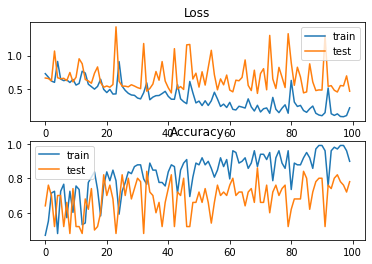

In [74]:
	
# mlp for the circles problem with cross entropy loss
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# define model
model = Sequential()
model.add(Dense(50, input_dim=2261, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.04, momentum=0.5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# fit model
history = model.fit(XTrain, YTrain, validation_data=(XTest, YTest), epochs=100, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(XTrain, YTrain, verbose=0)
_, test_acc = model.evaluate(XTest, YTest, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()